# GISTDA Wildfire Machine Learning Training

## Import Library Packages

#### Core Libraries
- **numpy**: A powerful library for numerical computing, providing support for arrays, matrices, and a wide range of mathematical operations.
- **pandas**: A versatile library for data manipulation and analysis, offering easy-to-use data structures like `DataFrame` for handling tabular data.

#### Visualization Libraries
- **matplotlib.pyplot**: A plotting library for creating static, animated, and interactive visualizations in Python.
- **seaborn**: Built on top of Matplotlib, this library provides a high-level interface for drawing attractive and informative statistical graphics.

#### Geospatial Libraries
- **rasterio**: A library for reading and writing geospatial raster data, commonly used for remote sensing and GIS applications.
  - **rasterio.windows.Window**: A tool to define a specific rectangular region (window) within a raster dataset for operations.

#### Logging
- **logging**: A built-in Python module to record log messages, useful for debugging and monitoring program execution.

#### File Handling
- **os**: A module providing tools to interact with the operating system, such as reading/writing files and directory management.
- **pickle**: A module for serializing and deserializing Python objects for storage or transmission.

#### Data Preprocessing
- **sklearn.preprocessing.MinMaxScaler**: A preprocessing tool from scikit-learn that scales and normalizes data within a specified range, often [0, 1].

#### Display Utilities
- **IPython.display.display**: A utility to control the display of outputs in Jupyter notebooks.
- **IPython.display.Markdown**: Enables the rendering of Markdown text in a Jupyter notebook.

#### Deep Learning Libraries
- **tensorflow**: A popular open-source framework for machine learning and deep learning. It supports building and training neural networks efficiently.
  - **tensorflow.keras.models.Sequential**: A simple model-building API for stacking layers sequentially.
  - **tensorflow.keras.layers.Dense**: A fully connected neural network layer.
  - **tensorflow.keras.layers.Dropout**: A regularization technique to prevent overfitting by randomly dropping neurons during training.
  - **tensorflow.keras.callbacks.EarlyStopping**: Stops training when a monitored metric stops improving.
  - **tensorflow.keras.callbacks.ReduceLROnPlateau**: Adjusts the learning rate when a metric stops improving.

#### Evaluation Metrics
- **sklearn.metrics.classification_report**: Generates a detailed report of classification metrics, including precision, recall, and F1 score.
- **sklearn.metrics.confusion_matrix**: Computes a confusion matrix to evaluate classification accuracy.
- **sklearn.metrics.roc_curve**: Computes Receiver Operating Characteristic (ROC) curve metrics.
- **sklearn.metrics.auc**: Computes the Area Under the Curve (AUC) for a ROC curve.

#### Typing
- **typing**: Provides tools for type annotations to improve code clarity and static analysis.
  - **Tuple, Dict, Any, List**: Common data types used in type hinting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import logging
import os
import pickle
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Markdown
from rasterio.windows import Window
from typing import Tuple, Dict, Any, List
from dask import delayed, compute

import tensorflow as tf
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import classification_report, confusion_matrix

## Import Raster GeoTIFF files

This code reads large raster files in manageable chunks, processes each chunk, and stores the data in a consolidated DataFrame.

1. **Folder Path and Chunk Size**: Sets the path to the folder containing raster files (`raster_train_file_path`) and defines the chunk size (`CHUNK_SIZE`).

2. **`read_raster_in_chunks` Function**:
   - Reads a raster file chunk-by-chunk.
   - For each chunk, it extracts data from all bands, along with the pixel coordinates.
   - Stores each chunk's data in a temporary DataFrame, which is added to a list.

3. **Task Creation**:
   - Creates a list of tasks using Dask's `@delayed` to process each raster file in parallel.

4. **Compute and Combine**:
   - Computes each task to get individual DataFrames for each file, then combines them into a final DataFrame (`final_df`).

5. **Debug Outputs**:
   - Prints the shape, columns, and a sample of the final DataFrame for inspection.

In [2]:
# Define the folder containing the raster files
raster_train_file_path = r'Raster_Train'

# Parameters for chunk size
CHUNK_SIZE = 1024

@delayed
def read_raster_in_chunks(raster_path, file, root):
    with rasterio.open(raster_path) as src:
        height, width = src.height, src.width
        num_bands = src.count
        band_names = [f'B{str(i).zfill(2)}' for i in range(1, num_bands + 1)]
        chunk_dfs = []
        
        # Loop over the raster in chunks
        for row in range(0, height, CHUNK_SIZE):
            for col in range(0, width, CHUNK_SIZE):
                window = Window(col_off=col, row_off=row, 
                              width=min(CHUNK_SIZE, width - col),
                              height=min(CHUNK_SIZE, height - row))
                
                # Read all bands at once
                data = src.read(window=window)
                
                # Check if chunk contains any data
                if np.any(data):
                    rows, cols = data[0].shape
                    
                    # Create base DataFrame with coordinates
                    row_coords, col_coords = np.meshgrid(
                        np.arange(row, row + rows),
                        np.arange(col, col + cols),
                        indexing="ij"
                    )
                    
                    chunk_df = pd.DataFrame({
                        'raster_file': file,
                        'subfolder': os.path.basename(root),
                        'x': row_coords.flatten(),
                        'y': col_coords.flatten()
                    })
                    
                    # Add each band's data
                    for band_idx, band_name in enumerate(band_names, 1):
                        chunk_df[band_name] = data[band_idx-1].flatten()
                    
                    chunk_dfs.append(chunk_df)
        
        return pd.concat(chunk_dfs, ignore_index=True) if chunk_dfs else pd.DataFrame()

# Create list of tasks
dask_dfs = [
    read_raster_in_chunks(os.path.join(root, file), file, root)
    for root, dirs, files in os.walk(raster_train_file_path)
    for file in files if file.endswith('.tif')
]

# Compute all tasks
dataframes = compute(*dask_dfs)

# Combine all DataFrames
final_df = pd.concat(dataframes, ignore_index=True)

# Debug prints
print("DataFrame shape:", final_df.shape)
print("\nDataFrame columns:", final_df.columns.tolist())
print("\nSample of data:")
print(final_df.head())

DataFrame shape: (140535808, 20)

DataFrame columns: ['raster_file', 'subfolder', 'x', 'y', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16']

Sample of data:
                            raster_file     subfolder  x  y    B01     B02  \
0  T46QGF_20230316T040541_chunk_0_0.tif  Raster_Train  0  0    1.0  1554.0   
1  T46QGF_20230316T040541_chunk_0_0.tif  Raster_Train  0  1    1.0  1600.0   
2  T46QGF_20230316T040541_chunk_0_0.tif  Raster_Train  0  2  603.0  1592.0   
3  T46QGF_20230316T040541_chunk_0_0.tif  Raster_Train  0  3  603.0  1678.0   
4  T46QGF_20230316T040541_chunk_0_0.tif  Raster_Train  0  4  858.0  1698.0   

      B03     B04     B05     B06     B07     B08     B09     B10     B11  \
0  1752.0  1930.0  2277.0  2576.0  2712.0  2812.0  2959.0  3042.0  3627.0   
1  1788.0  1912.0  2277.0  2576.0  2712.0  2850.0  2959.0  3042.0  3627.0   
2  1790.0  2002.0  2413.0  2643.0  2836.0  2782.0  3120.0  3042.0  3786.0   
3 

## Exploratory Data Analysis (EDA) & Feature Engineering

This code performs several operations on a DataFrame (`final_df`), converting it to a Dask DataFrame for distributed processing, renaming columns, and dropping unnecessary columns:

1. **Convert to Dask DataFrame**:
   - Converts the existing Pandas DataFrame (`final_df`) into a Dask DataFrame (`ddf`) to enable parallel, distributed processing.

2. **Rename Columns**:
   - Defines a list of new column names for Sentinel-2 bands and other data (`new_col_names`).
   - Renames `ddf` columns using this list to make them more descriptive.

3. **Drop Unneeded Columns**:
   - Drops columns such as `raster_file`, `subfolder`, `x`, `y`, and `dNBR`, keeping only essential information in the DataFrame (`df`).

4. **Display DataFrame**:
   - Uses `display()` to view the DataFrame when needed, triggering Dask's computation.

In [3]:
# Convert to Dask DataFrame
ddf = pd.DataFrame(final_df)  # Adjust npartitions as needed

# Rename Sentinel-2 Bands columns
new_col_names = ['raster_file', 'subfolder', 'x', 'y', 'Band_1', 'Band_2', 'Band_3', 'Band_4', 'Band_5', 
                 'Band_6', 'Band_7', 'Band_8', 'Band_8A', 'Band_9', 'Band_11', 'Band_12', 'dNBR',
                 'NDVI', 'NDWI', 'Burn_Label']

# Rename columns
final_df.columns = new_col_names

# Drop columns using Dask method
df = final_df.drop(columns=['raster_file', 'subfolder', 'x', 'y', 'dNBR'])
display(df)  # Compute only when you need to display or save results

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_8A,Band_9,Band_11,Band_12,NDVI,NDWI,Burn_Label
0,1.0,1554.0,1752.0,1930.0,2277.0,2576.0,2712.0,2812.0,2959.0,3042.0,3627.0,2993.0,0.185997,-0.232252,0.0
1,1.0,1600.0,1788.0,1912.0,2277.0,2576.0,2712.0,2850.0,2959.0,3042.0,3627.0,2993.0,0.196976,-0.228978,0.0
2,603.0,1592.0,1790.0,2002.0,2413.0,2643.0,2836.0,2782.0,3120.0,3042.0,3786.0,3110.0,0.163043,-0.216973,0.0
3,603.0,1678.0,1863.0,2142.0,2413.0,2643.0,2836.0,2974.0,3120.0,3042.0,3786.0,3110.0,0.162627,-0.229688,0.0
4,858.0,1698.0,1932.0,2224.0,2504.0,2747.0,2843.0,3004.0,3109.0,3042.0,3696.0,3002.0,0.149197,-0.217180,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140535803,1594.0,1753.0,2010.0,2354.0,2916.0,3358.0,3660.0,3678.0,3959.0,3943.0,5054.0,3881.0,0.219496,-0.293249,0.0
140535804,1569.0,1894.0,2138.0,2598.0,2984.0,3250.0,3564.0,3792.0,3953.0,3943.0,5176.0,3988.0,0.186854,-0.278921,0.0
140535805,1569.0,1844.0,2068.0,2438.0,2984.0,3250.0,3564.0,3578.0,3953.0,3943.0,5176.0,3988.0,0.189495,-0.267446,0.0
140535806,1553.0,1736.0,2009.0,2368.0,2723.0,3050.0,3321.0,3498.0,3729.0,3943.0,4897.0,3756.0,0.192636,-0.270383,0.0


### Check Burn Class

This code checks and displays the counts of burn records in the DataFrame:

1. **Count Burn Labels**:
   - Counts occurrences in the `Burn_Label` column to determine the number of "Burn" and "Unburn" records.
   - Renames the labels: `1` to "Burn" and `0` to "Unburn" for readability.

2. **Display Counts**:
   - Prints the resulting counts to show the distribution of burn and unburned areas.

In [4]:
# Check Burn Records
burn_counts = df['Burn_Label'].value_counts().rename(index={1: 'Burn', 0: 'Unburn'})

# Display the counts with labels
print(burn_counts)

Burn_Label
Unburn    130892491
Burn        9643317
Name: count, dtype: int64


### Downsampling

This code performs downsampling to balance the dataset by reducing the number of "Unburn" records to match the count of "Burn" records:

1. **Get Burn Count**:
   - Retrieves the count of "Burn" records from `burn_counts`.

2. **Sample Unburned Records**:
   - Selects a random sample of "Unburn" records, equal in size to the number of "Burn" records, using a fixed `random_state` for reproducibility.

3. **Combine Burn and Downsampled Unburn Records**:
   - Combines all "Burn" records with the downsampled "Unburn" sample into a new DataFrame (`downsampled_df`).

4. **Check New Burn Record Counts**:
   - Counts and displays the "Burn" and "Unburn" records in `downsampled_df` to verify balance.

In [5]:
burn_count = burn_counts['Burn']
unburn_sample = df[df['Burn_Label'] == 0].sample(n=burn_count, random_state=42)

downsampled_df = pd.concat([df[df['Burn_Label'] == 1], unburn_sample])

# Check Burn Records
burn_counts = downsampled_df['Burn_Label'].value_counts().rename(index={1: 'Burn', 0: 'Unburn'})

# Display the counts with labels
print(burn_counts)

Burn_Label
Burn      9643317
Unburn    9643317
Name: count, dtype: int64


### Remove infinite values

This code handles the presence of infinite values and missing data in the `downsampled_df` DataFrame:

1. **Replace Infinite Values**:
   - Replaces both positive and negative infinite values (`np.inf` and `-np.inf`) with `NaN` using `replace()`. This ensures that infinite values do not interfere with further processing.

2. **Drop Rows with Missing Values**:
   - Removes any rows containing `NaN` values using `dropna()`, ensuring the DataFrame only contains valid data.

3. **Display the DataFrame**:
   - Displays the cleaned DataFrame (`downsampled_df`) for inspection.

In [6]:
# Replacing infinite with nan 
downsampled_df.replace([np.inf, -np.inf], np.nan, inplace=True) 
  
# Dropping all the rows with nan values 
downsampled_df.dropna(inplace=True)

# Printing df 
display(downsampled_df)

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_8A,Band_9,Band_11,Band_12,NDVI,NDWI,Burn_Label
18,703.0,1614.0,1767.0,1956.0,2193.0,2333.0,2382.0,2498.0,2556.0,2473.0,3356.0,3200.0,0.121688,-0.171395,1.0
19,703.0,1650.0,1800.0,1977.0,2193.0,2333.0,2382.0,2410.0,2556.0,2473.0,3356.0,3200.0,0.098701,-0.144893,1.0
20,729.0,1689.0,1796.0,1990.0,2155.0,2194.0,2286.0,2272.0,2405.0,2473.0,3118.0,3100.0,0.066166,-0.117011,1.0
21,729.0,1672.0,1846.0,1990.0,2155.0,2194.0,2286.0,2266.0,2405.0,2473.0,3118.0,3100.0,0.064850,-0.102140,1.0
22,740.0,1706.0,1822.0,1996.0,2122.0,2159.0,2214.0,2234.0,2317.0,2473.0,3010.0,3035.0,0.056265,-0.101578,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44986292,1597.0,1786.0,2076.0,2424.0,2625.0,2990.0,3102.0,3494.0,3290.0,3051.0,4325.0,3735.0,0.180804,-0.254578,0.0
49402550,1686.0,1891.0,2234.0,2708.0,3091.0,3315.0,3582.0,3746.0,3974.0,3903.0,5178.0,4062.0,0.160830,-0.252843,0.0
4082444,1753.0,1925.0,2306.0,2224.0,2221.0,1765.0,1781.0,1692.0,1627.0,1587.0,1367.0,1297.0,-0.135853,0.153577,0.0
8304608,1638.0,1744.0,2020.0,2320.0,2692.0,2986.0,3217.0,3262.0,3537.0,3564.0,4461.0,3556.0,0.168757,-0.235138,0.0


### Seperate Burn_Label from DataFrame

This code separates the `Burn_Label` from the main DataFrame and ensures the label is in the correct format:

1. **Separate Burn Label**:
   - Extracts the `Burn_Label` column from `downsampled_df` into a new DataFrame (`burn_label`).

2. **Remove Burn Label from Main DataFrame**:
   - Drops the `Burn_Label` column from `downsampled_df` to ensure only the feature data remains.

3. **Convert Burn Label to Integer**:
   - Changes the data type of the `burn_label` DataFrame to `int32` to ensure consistent and efficient processing.

4. **Display Burn Label**:
   - Displays the modified `burn_label` DataFrame to verify the changes.

In [7]:
# Seperate Burn_Label from DataFrame
burn_label = downsampled_df[['Burn_Label']]

# Drop Label from DataFrame
downsampled_df = downsampled_df.drop(columns=['Burn_Label'])

# Change type of Label to Integer Format
burn_label = burn_label.astype('int32')
display(burn_label)

,Burn_Label
18,1
19,1
20,1
21,1
22,1
...,...
44986292,0
49402550,0
4082444,0
8304608,0


### Normalization Data with MinMax Scaler

This code normalizes the feature data and saves the normalization model, while also combining it with the `Burn_Label`:

1. **List Columns**:
   - Creates a list of column names from `downsampled_df` to keep track of the column order after normalization (`cols_norm`).

2. **Normalize the Data**:
   - Imports `MinMaxScaler` from `sklearn` and fits it to the data in `downsampled_df`, which scales the values between 0 and 1.

3. **Save the Scaler**:
   - Saves the fitted `MinMaxScaler` model to a specified path (`MinMax_Scaler.pkl`) for later use.

4. **Apply Normalization**:
   - Normalizes the data by applying the `scaler` to `downsampled_df`, then converts the result back into a DataFrame (`df_norm`) with the original column names.

5. **Check Shape**:
   - Prints the shape of `df_norm` to confirm the normalization was applied correctly.

6. **Concatenate with Burn Label**:
   - Combines the normalized feature data (`df_norm`) with the `burn_label` DataFrame, aligning them by their indices and ensuring the result is a complete dataset.

7. **Display the DataFrame**:
   - Displays the final DataFrame (`df_norm`), which now includes both the normalized features and the `Burn_Label`.


In [8]:
# Reassign the dataframe with a list of the columns
cols_norm = downsampled_df.columns.tolist()

# Import Normalize technique
scaler = MinMaxScaler()

# Normalize data
scaler.fit(downsampled_df)

# Save the scaler
scaler_save_path = r'Export Model'
save_path = os.path.join(scaler_save_path, 'MinMax_Scaler_DL.pkl')
os.makedirs(os.path.dirname(save_path), exist_ok=True)
with open(save_path, 'wb') as f:
    pickle.dump(scaler, f)

# Normalize Data
df_norm = scaler.transform(downsampled_df)
df_norm = pd.DataFrame(df_norm, columns=cols_norm)

# Check df_norm shape after normalization
print("Shape of df_norm after normalization:", df_norm.shape)

# Concatenate df_norm with burn_label
df_norm = pd.concat([df_norm.reset_index(drop=True), burn_label.reset_index(drop=True)], axis=1, sort=False)
display(df_norm)

Shape of df_norm after normalization: (19255766, 14)


,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_8A,Band_9,Band_11,Band_12,NDVI,NDWI,Burn_Label
0,0.034687,0.034606,0.041938,0.056314,0.069293,0.078759,0.082395,0.147927,0.100746,0.143515,0.144833,0.139308,0.647258,0.291251,1
1,0.034687,0.036556,0.043827,0.057565,0.069293,0.078759,0.082395,0.142713,0.100746,0.143515,0.144833,0.139308,0.633982,0.307302,1
2,0.035972,0.038668,0.043598,0.058340,0.066979,0.070119,0.076357,0.134538,0.091202,0.143515,0.129800,0.132888,0.615191,0.324188,1
3,0.035972,0.037747,0.046458,0.058340,0.066979,0.070119,0.076357,0.134182,0.091202,0.143515,0.129800,0.132888,0.614431,0.333195,1
4,0.036515,0.039588,0.045085,0.058697,0.064970,0.067943,0.071828,0.132287,0.085640,0.143515,0.122979,0.128715,0.609473,0.333535,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19255761,0.078862,0.043921,0.059618,0.084202,0.095598,0.119600,0.127681,0.206931,0.147137,0.178108,0.206038,0.173653,0.681400,0.240871,0
19255762,0.083259,0.049607,0.068658,0.101126,0.123972,0.139802,0.157872,0.221860,0.190368,0.229098,0.259917,0.194646,0.669865,0.241922,0
19255763,0.086570,0.051449,0.072777,0.072284,0.070998,0.043451,0.044594,0.100178,0.042030,0.090490,0.019202,0.017141,0.498515,0.488068,0
19255764,0.080887,0.041646,0.056414,0.078005,0.099677,0.119351,0.134914,0.193187,0.162748,0.208810,0.214629,0.162162,0.674442,0.252645,0


## Deep Learning Hyperparameters Analysis & Training

INFO:__main__:GPU is available and will be used for training.
INFO:__main__:GPU: /physical_device:GPU:0


Epoch 1/10
601743/601743 [==============================] - 851s 1ms/step - loss: 0.0401 - accuracy: 0.9866
Epoch 2/10
601743/601743 [==============================] - 866s 1ms/step - loss: 0.0325 - accuracy: 0.9894
Epoch 3/10
601743/601743 [==============================] - 862s 1ms/step - loss: 0.0307 - accuracy: 0.9900
Epoch 4/10
601743/601743 [==============================] - 892s 1ms/step - loss: 0.0297 - accuracy: 0.9904
Epoch 5/10
601743/601743 [==============================] - 907s 2ms/step - loss: 0.0290 - accuracy: 0.9906
Epoch 6/10
601743/601743 [==============================] - 844s 1ms/step - loss: 0.0286 - accuracy: 0.9908
Epoch 7/10
601743/601743 [==============================] - 849s 1ms/step - loss: 0.0282 - accuracy: 0.9909
Epoch 8/10
601743/601743 [==============================] - 873s 1ms/step - loss: 0.0279 - accuracy: 0.9910
Epoch 9/10
601743/601743 [==============================] - 819s 1ms/step - loss: 0.0277 - accuracy: 0.9911
Epoch 10/10
601743/601743 [=

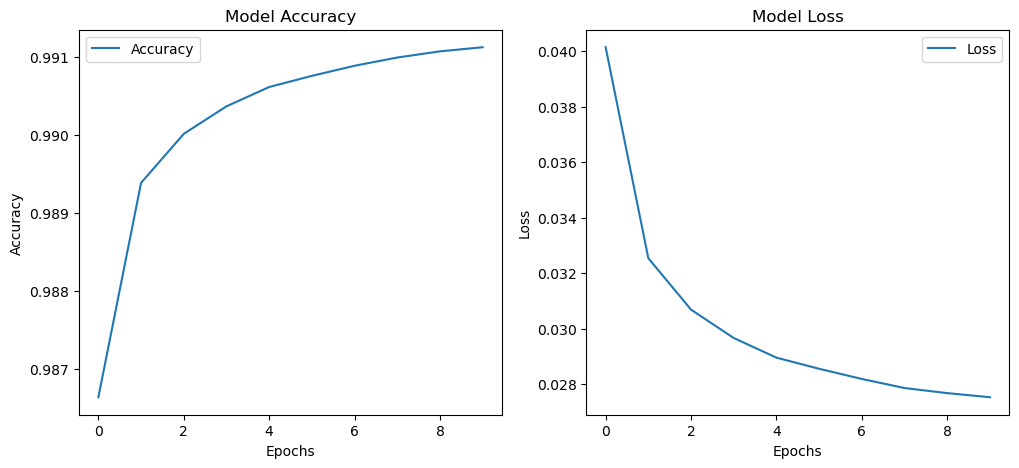

C:\Users\admin\AppData\Local\Temp\ipykernel_25516\467261941.py:59: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator=tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=lambda: build_model(hidden_layers=3),


Epoch 1/2
541569/541569 [==============================] - 739s 1ms/step - loss: 0.0385 - accuracy: 0.9870
Epoch 2/2
60175/60175 [==============================] - 33s 546us/step
Epoch 1/2
541569/541569 [==============================] - 742s 1ms/step - loss: 0.0425 - accuracy: 0.9849
Epoch 2/2
60175/60175 [==============================] - 34s 573us/step
Epoch 1/2
541569/541569 [==============================] - 742s 1ms/step - loss: 0.0415 - accuracy: 0.9851
Epoch 2/2
60175/60175 [==============================] - 36s 599us/step
Epoch 1/2
541569/541569 [==============================] - 753s 1ms/step - loss: 0.0432 - accuracy: 0.9847
Epoch 2/2
60175/60175 [==============================] - 34s 569us/step
Epoch 1/2
541569/541569 [==============================] - 761s 1ms/step - loss: 0.0418 - accuracy: 0.9850
Epoch 2/2
60175/60175 [==============================] - 35s 578us/step
Epoch 1/2
541569/541569 [==============================] - 750s 1ms/step - loss: 0.0396 - accuracy: 0.986

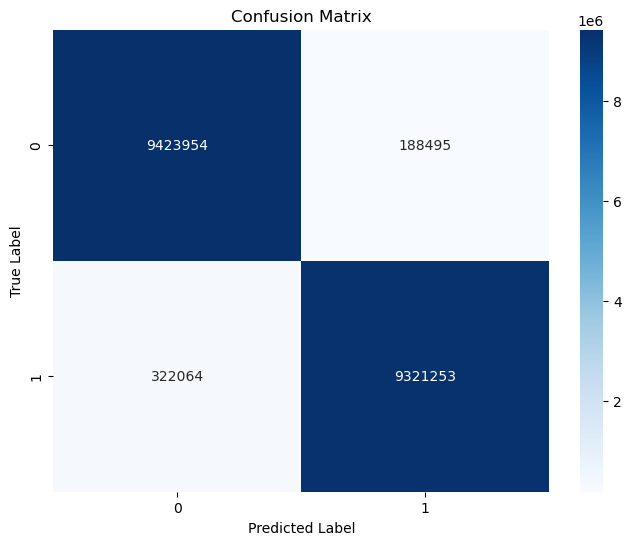

In [9]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    logger.info("GPU is available and will be used for training.")
    gpu_name = gpus[0].name
    logger.info(f"GPU: {gpu_name}")
else:
    logger.info("GPU is not available, training will be done on CPU.")

# Ensure df_norm is already defined and preprocessed
# Define the features and target
X = df_norm.drop(columns=['Burn_Label'])  # Features
y = df_norm['Burn_Label']  # Target

# Convert labels to one-hot encoding
y_onehot = tf.keras.utils.to_categorical(y, num_classes=y.nunique())

# Function to build the model
def build_model(hidden_layers=3):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X.shape[1],)))
    for _ in range(hidden_layers):
        model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Grid Search for Best Hyperparameters
best_params = None
best_score = 0

# Train the Model with Best Hyperparameters on Entire Dataset
model = build_model(hidden_layers=3)
history = model.fit(X, y_onehot, epochs=10, batch_size=32, verbose=1)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Cross-Validation Predictions
y_pred = cross_val_predict(
    estimator=tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=lambda: build_model(hidden_layers=3),
                                                             epochs=2,
                                                             batch_size=32, verbose=1),
    X=X, y=y, cv=10
)

# Classification Report as Pandas DataFrame
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Confusion Matrix Heatmap
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Export Model

In [11]:
# Save the model as an HDF5 file
model.save('Export Model/DL_Model.h5')
logger.info("Model saved as 'DL_Model.h5'.")

INFO:__main__:Model saved as 'DL_Model.h5'.
